In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import toeplitz
import matplotlib.colors
import seaborn as sns
import matplotlib.patches as patches

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
filepath = "filtered_data/adjacent1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(286943, 66)


In [4]:
df['order'] = df.groupby(['cell', 'read_name'])['read_name'].transform("count")
df['order'] = df['order'] + 1 # need to add one

df['order'].value_counts(normalize=True)

2     0.373998
3     0.266102
4     0.146120
5     0.088756
6     0.050724
7     0.030905
8     0.017467
9     0.010009
10    0.006085
11    0.004112
12    0.002108
13    0.001380
14    0.000951
16    0.000418
15    0.000390
17    0.000279
22    0.000073
19    0.000063
18    0.000059
Name: order, dtype: float64

cell='run01' tmp['order'].max()=16 tmp['order'].min()=2
cell='run02' tmp['order'].max()=19 tmp['order'].min()=2
cell='run04' tmp['order'].max()=17 tmp['order'].min()=2
cell='run05' tmp['order'].max()=16 tmp['order'].min()=2
cell='run06' tmp['order'].max()=17 tmp['order'].min()=2
cell='run07' tmp['order'].max()=22 tmp['order'].min()=2


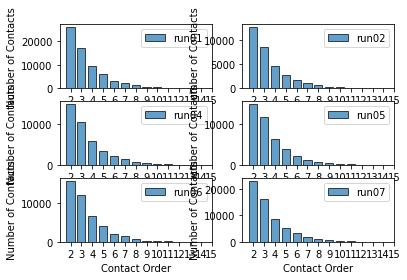

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 10

fig = plt.figure()

binMax = 15
histBins = np.linspace(2, binMax, binMax - 1)


for i, cell in enumerate(df['cell'].unique()):
    tmp = df[(df['cell'] == cell)].reset_index(drop=True)
    print(f"{cell=} {tmp['order'].max()=} {tmp['order'].min()=}")
    
    fig.add_subplot(3, 2, i+1)
    plt.hist(tmp['order'], 
             edgecolor='k', 
             bins=histBins, 
             label=cell, 
             alpha=0.7,
             rwidth=0.75)
    plt.legend()
    plt.xlabel('Contact Order')
    plt.ylabel('Number of Contacts')
    
    newLabels = [int(x) for x in histBins]
    newTicks = [x+0.5 for x in histBins]
    plt.xticks(newTicks, labels=newLabels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.XTick at 0x2b3641c03e50>,
 [Text(2.5, 0, '2'),
  Text(3.5, 0, '3'),
  Text(4.5, 0, '4'),
  Text(5.5, 0, '5'),
  Text(6.5, 0, '6'),
  Text(7.5, 0, '7'),
  Text(8.5, 0, '8'),
  Text(9.5, 0, '9'),
  Text(10.5, 0, '10'),
  Text(11.5, 0, '11'),
  Text(12.5, 0, '12'),
  Text(13.5, 0, '13'),
  Text(14.5, 0, '14'),
  Text(15.5, 0, '15')])

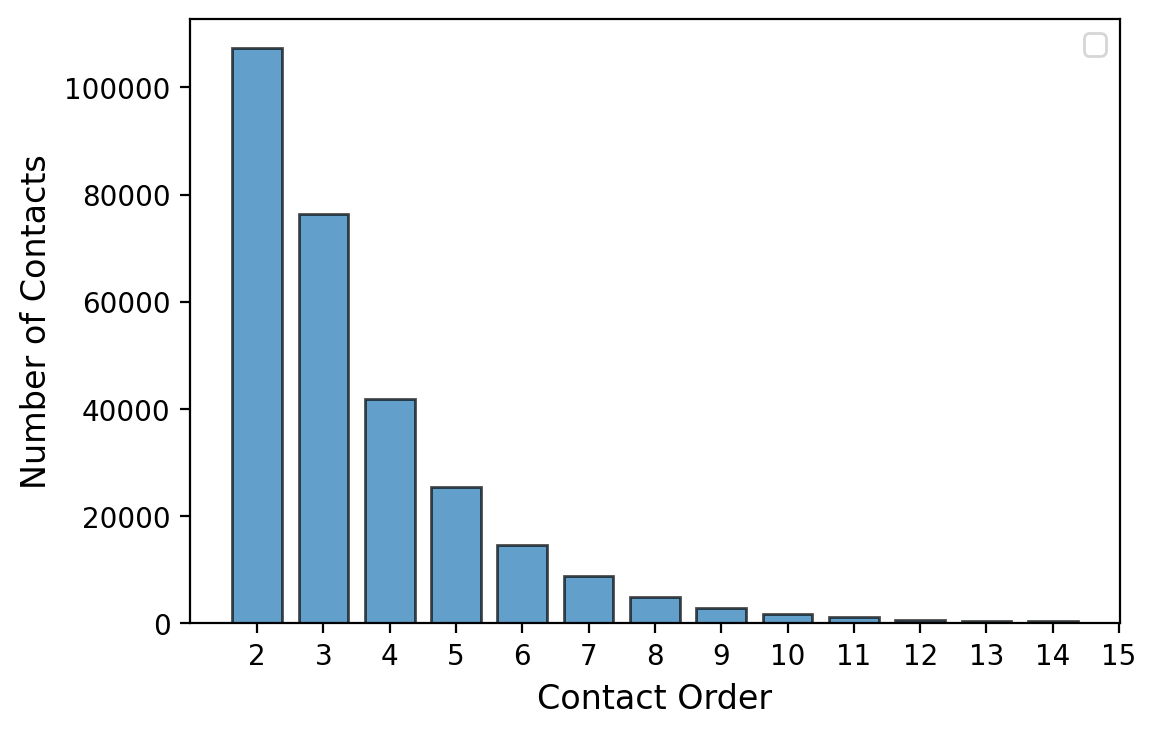

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

fontsize = 12
fig = plt.figure()

binMax = 15
histBins = np.linspace(2, binMax, binMax - 1)

plt.hist(df['order'], 
         edgecolor='k', 
         bins=histBins, 
         alpha=0.7,
         rwidth=0.75)
plt.legend()
plt.xlabel('Contact Order',fontsize=fontsize)
plt.ylabel('Number of Contacts',fontsize=fontsize)

newLabels = [int(x) for x in histBins]
newTicks = [x+0.5 for x in histBins]
plt.xticks(newTicks, labels=newLabels)

# Need to re-load to use expanded contacts

In [7]:
# filepath = "filtered_data/clique1MBfiltered.csv"

# df = pd.read_csv(filepath)
# print(f"{df.shape=}")

# # order computations are made using the existing mapped fragments
# orderDict = {}

# nReads = df['read_name'].nunique()
# print(f"{nReads=}")


# for i, read in enumerate(df['read_name'].unique()):
    
#     if i % 4000 == 0:
#         print(f"{i}/{nReads}")
        
#     tmp = df[df['read_name'] == read ]
#     frags = tmp['align1_fragment_id'].to_list() + tmp['align2_fragment_id'].to_list()
#     nContacts = len(set(frags))
#     orderDict[read] = nContacts
    
    
# df['order'] = df['read_name'].map(orderDict)

# expandedOrder = df[['read_name', 'order']]
# outpath = "filtered_data/cliq1MBOrder.csv"
# expandedOrder.to_csv(outpath, index=False)
# print("done.")


# print(f"{np.median(df['order'])=}")

# df['order'].value_counts(normalize=True)

In [8]:
filepath = "filtered_data/clique1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")

ordPath = "filtered_data/cliq1MBOrder.csv"
expOrder = pd.read_csv(ordPath)
print(f"{expOrder.shape=}")

"""
WARNING: depends on consistent ordering
"""

df['order'] = expOrder['order']
print(f"{np.median(df['order'])=}")

df['order'].value_counts(normalize=True)

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(636130, 65)
expOrder.shape=(636130, 2)
np.median(df['order'])=4.0


3     0.255855
4     0.238673
2     0.194182
5     0.155597
6     0.086160
7     0.041416
8     0.018515
9     0.006255
10    0.001781
13    0.000552
12    0.000440
11    0.000288
17    0.000286
Name: order, dtype: float64

In [28]:
df['contact_is_cis'].value_counts(normalize=True)

True     0.86008
False    0.13992
Name: contact_is_cis, dtype: float64

([<matplotlib.axis.XTick at 0x2b364350b520>,
 [Text(2.5, 0, '2'),
  Text(3.5, 0, '3'),
  Text(4.5, 0, '4'),
  Text(5.5, 0, '5'),
  Text(6.5, 0, '6'),
  Text(7.5, 0, '7'),
  Text(8.5, 0, '8'),
  Text(9.5, 0, '9'),
  Text(10.5, 0, '10'),
  Text(11.5, 0, '11'),
  Text(12.5, 0, '12'),
  Text(13.5, 0, '13'),
  Text(14.5, 0, '14'),
  Text(15.5, 0, '15')])

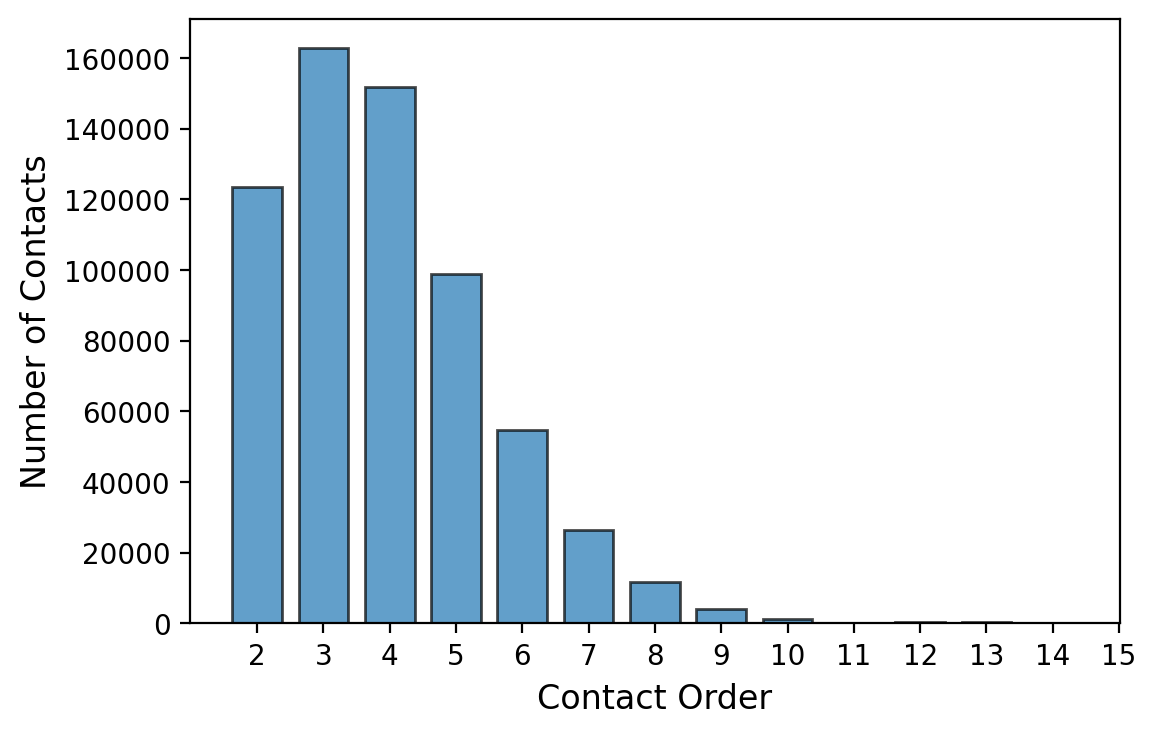

In [9]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

fontsize = 12
fig = plt.figure()

binMax = 15
histBins = np.linspace(2, binMax, binMax - 1)

plt.hist(df['order'], 
         edgecolor='k', 
         color='C0',
         bins=histBins, 
         alpha=0.7,
         rwidth=0.75)

plt.xlabel('Contact Order',fontsize=fontsize)
plt.ylabel('Number of Contacts',fontsize=fontsize)
# plt.title("HIST FORM EXPANDED")

newLabels = [int(x) for x in histBins]
newTicks = [x+0.5 for x in histBins]
plt.xticks(newTicks, labels=newLabels)

In [10]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

hoSplit = {}
indShape = None

for cell in df['cell'].unique():
    
    cellPairs = df[(df['cell'] == cell) & (df['order'] == 2)].reset_index(drop=True)
    cellHigherOrder = df[(df['cell'] == cell) & (df['order'] > 2)].reset_index(drop=True)
    
    pairsBinned = binning.wholeGenomeBinData(cellPairs, bins, label1, label2)
    hoBinned = binning.wholeGenomeBinData(cellHigherOrder, bins, label1, label2)
    
    Apairs = pcu.getHic(pairsBinned, bins, label1, label2)
    Aho = pcu.getHic(hoBinned, bins, label1, label2)
    
    print(f"{cell=}")
    print(f"\t {cellPairs.shape=} {cellHigherOrder.shape=} {Apairs.shape=}")
    indShape = Apairs.shape[0]
    
    hoSplit[cell] = {
        'pairs' : Apairs,
        'higherOrder' : Aho,
    }
    
print('done.')

cell='run01'
	 cellPairs.shape=(27314, 68) cellHigherOrder.shape=(118917, 68) Apairs.shape=(2724, 2724)
cell='run02'
	 cellPairs.shape=(14295, 68) cellHigherOrder.shape=(58589, 68) Apairs.shape=(2724, 2724)
cell='run04'
	 cellPairs.shape=(17151, 68) cellHigherOrder.shape=(72756, 68) Apairs.shape=(2724, 2724)
cell='run05'
	 cellPairs.shape=(18648, 68) cellHigherOrder.shape=(71348, 68) Apairs.shape=(2724, 2724)
cell='run06'
	 cellPairs.shape=(18989, 68) cellHigherOrder.shape=(75748, 68) Apairs.shape=(2724, 2724)
cell='run07'
	 cellPairs.shape=(27128, 68) cellHigherOrder.shape=(115247, 68) Apairs.shape=(2724, 2724)
done.


In [11]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)
filteredPoreCIndex = list(range(0, indShape))

In [12]:
chromosome = ['chr2']

chrom2 = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    return A
    

for runId in hoSplit.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    Apairs = processMat(hoSplit[runId]['pairs'], ind)
    Aho = processMat(hoSplit[runId]['higherOrder'], ind)
    
    chrom2[runId] = {
        'pairs' : Apairs,
        'higherOrder' : Aho
    }
    
    
print('done.')

done.


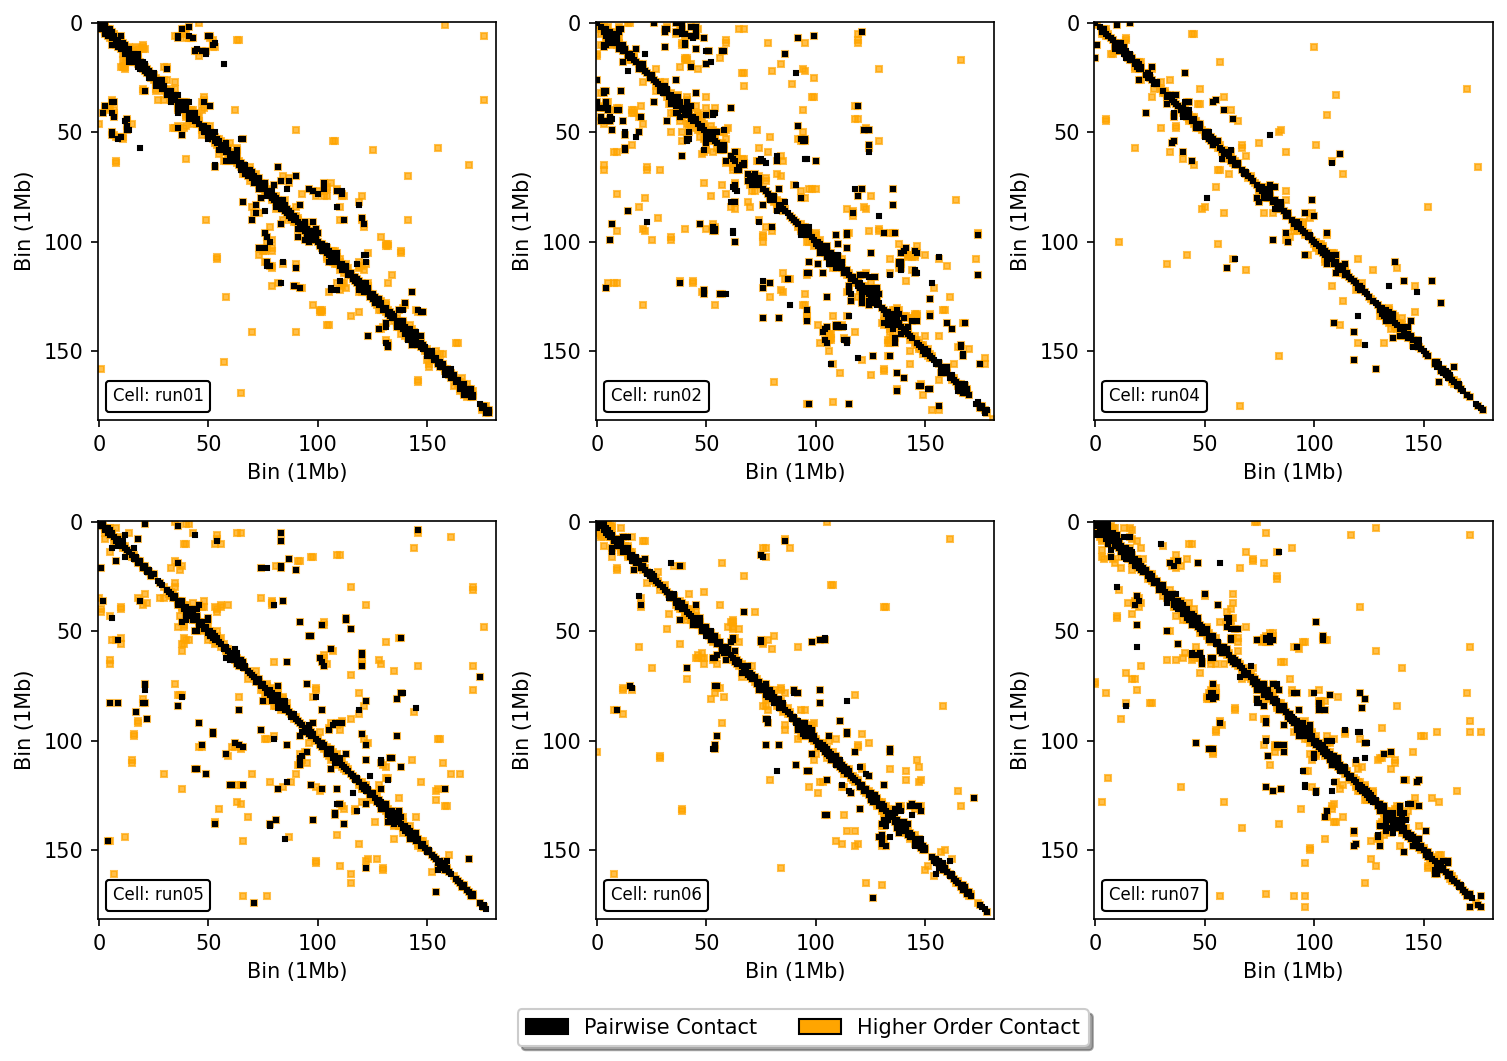

In [13]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 12, 12

fig = plt.figure()
legend_elements = [Patch(facecolor='k', edgecolor='k', label='Pairwise Contact'),
                   Patch(facecolor='orange', edgecolor='k', label='Higher Order Contact')]

pltNum = 0
for runId, mats in chrom2.items():
    pltNum += 1

    fig.add_subplot(2, 3, pltNum)
    
    plt.spy(mats['higherOrder'], c='orange', alpha=0.7, marker='s', markersize=3)
    plt.spy(mats['pairs'], c='k', marker='s', markersize=2)
    
    plt.xlabel('Bin (1Mb)')
    plt.ylabel('Bin (1Mb)')
    
    
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    
    at = AnchoredText(
        f"Cell: {runId}", prop=dict(size=8), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.set_aspect('equal')
    
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(-.73, -0.2),
          fancybox=True, shadow=True, ncol=5)
    
plt.subplots_adjust(wspace=0.25, hspace=-0.42)

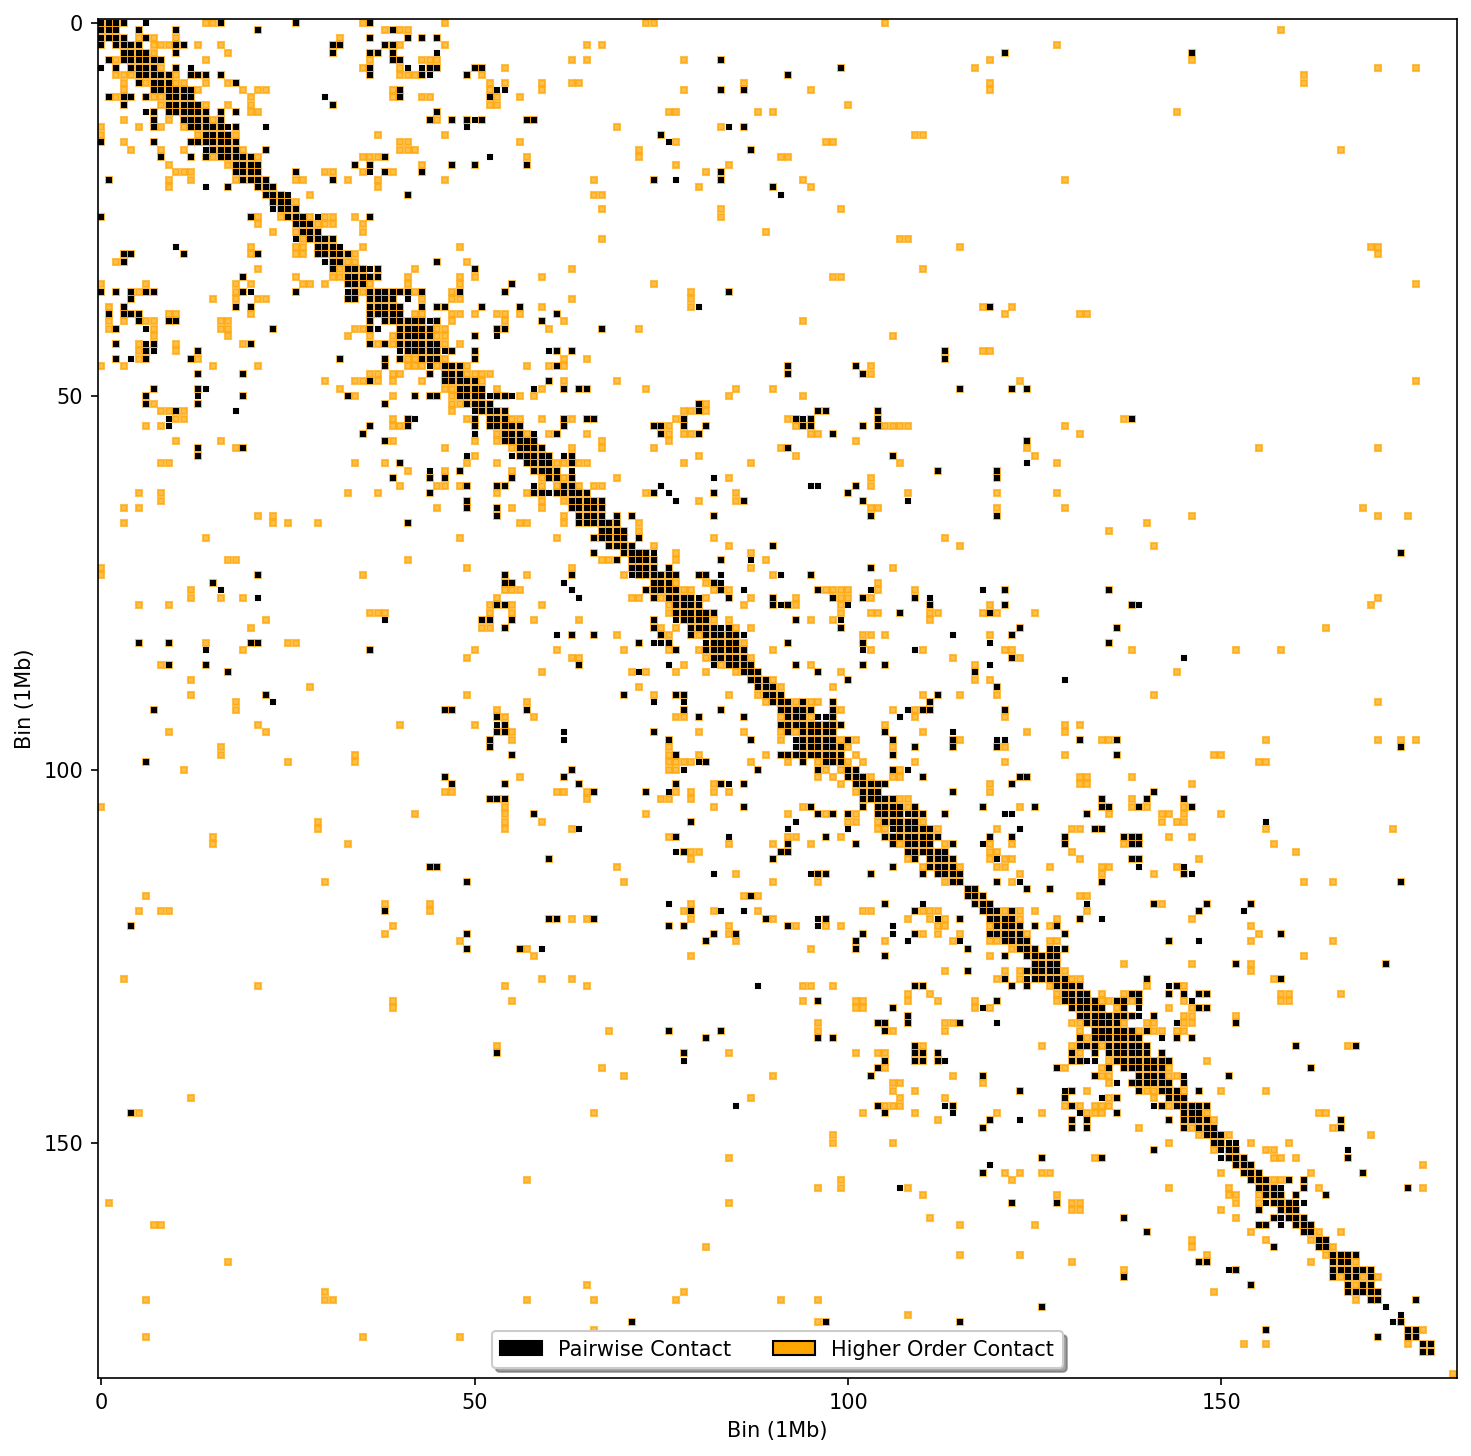

In [14]:
pairBulk = np.zeros((182, 182))
hoBulk = np.zeros((182, 182))

for runId, mats in chrom2.items():
    
    pairBulk += mats['pairs']
    hoBulk += mats['higherOrder']
    
    
pairBulk = pcu.Abin(pairBulk)
hoBulk = pcu.Abin(hoBulk)

    
plt.spy(hoBulk, c='orange', alpha=0.7, marker='s', markersize=3)
plt.spy(pairBulk, c='k', marker='s', markersize=2)

plt.xlabel('Bin (1Mb)')
plt.ylabel('Bin (1Mb)')

ax = plt.gca()
ax.xaxis.tick_bottom()

ax.set_aspect('equal')

plt.legend(handles=legend_elements, loc='lower center',
      fancybox=True, shadow=True, ncol=5)


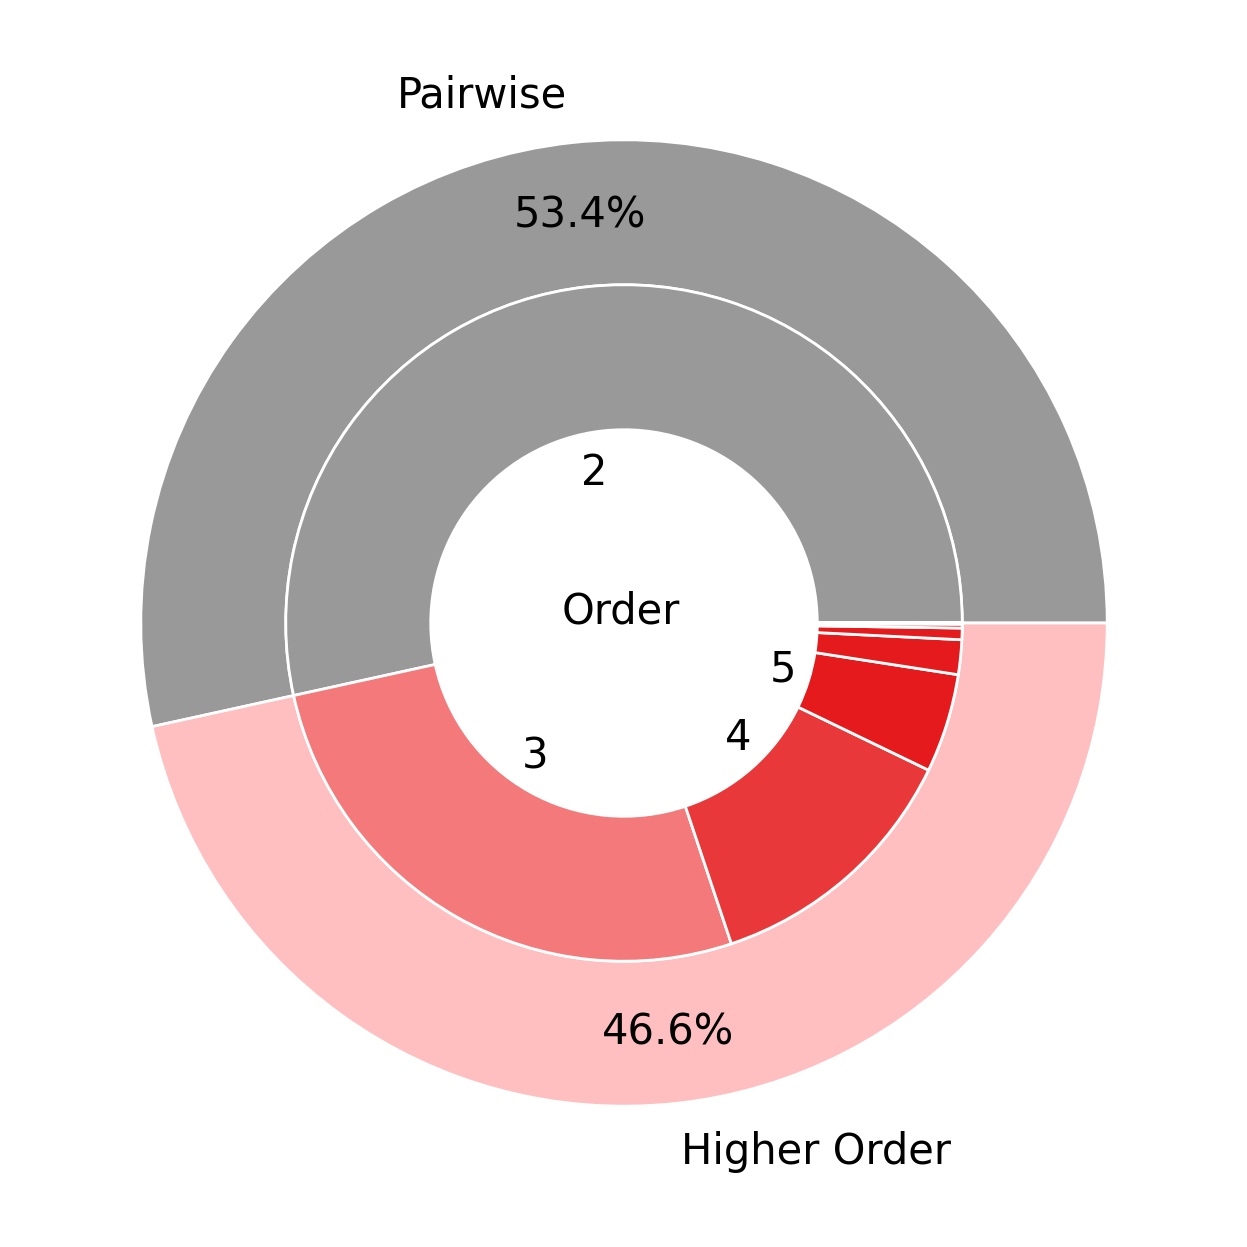

In [15]:
readCounts = df[['read_name', 'order']].drop_duplicates()

contactOrder = pd.DataFrame(readCounts['order'].value_counts(normalize=True))
contactOrder = contactOrder.reset_index()
contactOrder.columns = ['Order', 'Proportion']

pairProp = contactOrder.loc[contactOrder['Order'] == 2]['Proportion'].values[0]
highProp = 1 - pairProp
metaProp = [pairProp, highProp]

def categorical_cmap(nc, nsc, cmap="tab20", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

y = contactOrder['Proportion']
x = metaProp

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = 'w'
fig, ax = plt.subplots()

size = 0.3
fontsize = 15

cmap = categorical_cmap(2, 6, cmap="Set1", continuous=True)

outer_colors = cmap(x)
inner_colors = cmap(y)


ax.pie(x, 
       labels=['Pairwise', 'Higher Order'],
       textprops={'fontsize': fontsize},
       radius=1, 
       autopct='%1.1f%%',
       pctdistance=0.85,
       colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))



labels = []
labelCutOff = 6
for order in contactOrder['Order']:
    if order < labelCutOff:
        labels.append(f"{order}")
    elif order == labelCutOff:
        labels.append("")
    else:
        labels.append("")

ax.pie(y, 
       labels=labels,
       labeldistance=0.45,
       textprops={'fontsize': fontsize},
       radius=1-size, 
       colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.text(-0.13, 0, "Order", size=fontsize)

ax.set(aspect="equal")
plt.show()

In [16]:
# now we look at the same thing for clique expanded

filepath = "filtered_data/clique1MBfiltered.csv"

exp = pd.read_csv(filepath)
print(f"{exp.shape=}")

exp = pd.merge(left=exp, 
               right=readCounts,
               how='left',
               on='read_name')

print(f"{exp.shape=}")
print('done loading')

label1 = 'bin1'
label2 = 'bin2'

hoSplitExp = {}

for cell in exp['cell'].unique():
    
    cellPairs = exp[(exp['cell'] == cell) & (exp['order'] == 2)].reset_index(drop=True)
    cellHigherOrder = exp[(exp['cell'] == cell) & (exp['order'] > 2)].reset_index(drop=True)
    
    pairsBinned = binning.wholeGenomeBinData(cellPairs, bins, label1, label2)
    hoBinned = binning.wholeGenomeBinData(cellHigherOrder, bins, label1, label2)
    
    Apairs = pcu.getHic(pairsBinned, bins, label1, label2)
    Aho = pcu.getHic(hoBinned, bins, label1, label2)
    
    print(f"{cell=}")
    print(f"\t {cellPairs.shape=} {cellHigherOrder.shape=} {Apairs.shape=}")
    
    hoSplitExp[cell] = {
        'pairs' : Apairs,
        'higherOrder' : Aho,
    }
    
print('done binning.')

chromosome = ['chr2']

chrom2Exp = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    return A
    

for runId in hoSplitExp.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    Apairs = processMat(hoSplitExp[runId]['pairs'], ind)
    Aho = processMat(hoSplitExp[runId]['higherOrder'], ind)
    
    chrom2Exp[runId] = {
        'pairs' : Apairs,
        'higherOrder' : Aho
    }
    
print('done')

exp.shape=(636130, 65)
exp.shape=(636130, 66)
done loading
cell='run01'
	 cellPairs.shape=(27314, 68) cellHigherOrder.shape=(118917, 68) Apairs.shape=(2724, 2724)
cell='run02'
	 cellPairs.shape=(14295, 68) cellHigherOrder.shape=(58589, 68) Apairs.shape=(2724, 2724)
cell='run04'
	 cellPairs.shape=(17151, 68) cellHigherOrder.shape=(72756, 68) Apairs.shape=(2724, 2724)
cell='run05'
	 cellPairs.shape=(18648, 68) cellHigherOrder.shape=(71348, 68) Apairs.shape=(2724, 2724)
cell='run06'
	 cellPairs.shape=(18989, 68) cellHigherOrder.shape=(75748, 68) Apairs.shape=(2724, 2724)
cell='run07'
	 cellPairs.shape=(27128, 68) cellHigherOrder.shape=(115247, 68) Apairs.shape=(2724, 2724)
done binning.
done


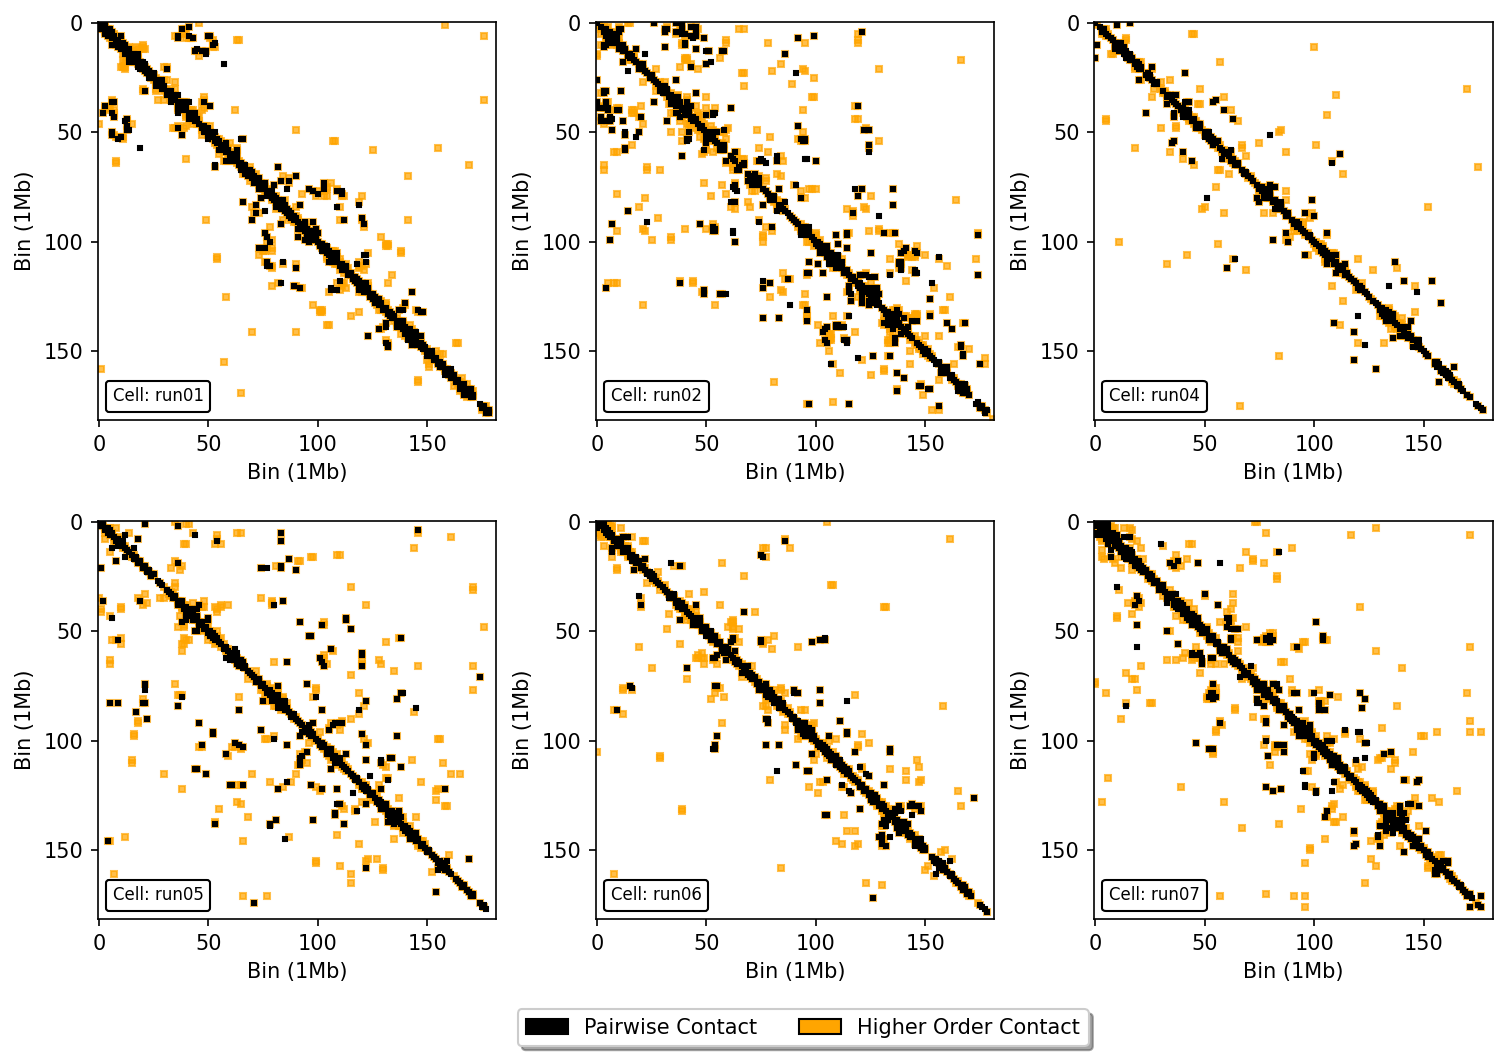

In [17]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 12, 12

fig = plt.figure()
legend_elements = [Patch(facecolor='k', edgecolor='k', label='Pairwise Contact'),
                   Patch(facecolor='orange', edgecolor='k', label='Higher Order Contact')]

pltNum = 0
for runId, mats in chrom2Exp.items():
    
#     aExp = mats['higherOrder']
#     aAdj = chrom2[runId]['higherOrder']
#     print(f"{np.linalg.norm(aExp - aAdj)=}")
    
    pltNum += 1
    fig.add_subplot(2, 3, pltNum)
    
    plt.spy(mats['higherOrder'], c='orange', alpha=0.7, marker='s', markersize=3)
    plt.spy(mats['pairs'], c='k', marker='s', markersize=2)
    
    plt.xlabel('Bin (1Mb)')
    plt.ylabel('Bin (1Mb)')
    
    
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    
    at = AnchoredText(
        f"Cell: {runId}", prop=dict(size=8), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.set_aspect('equal')
    
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(-.73, -0.2),
          fancybox=True, shadow=True, ncol=5)
    
plt.subplots_adjust(wspace=0.25, hspace=-0.42)

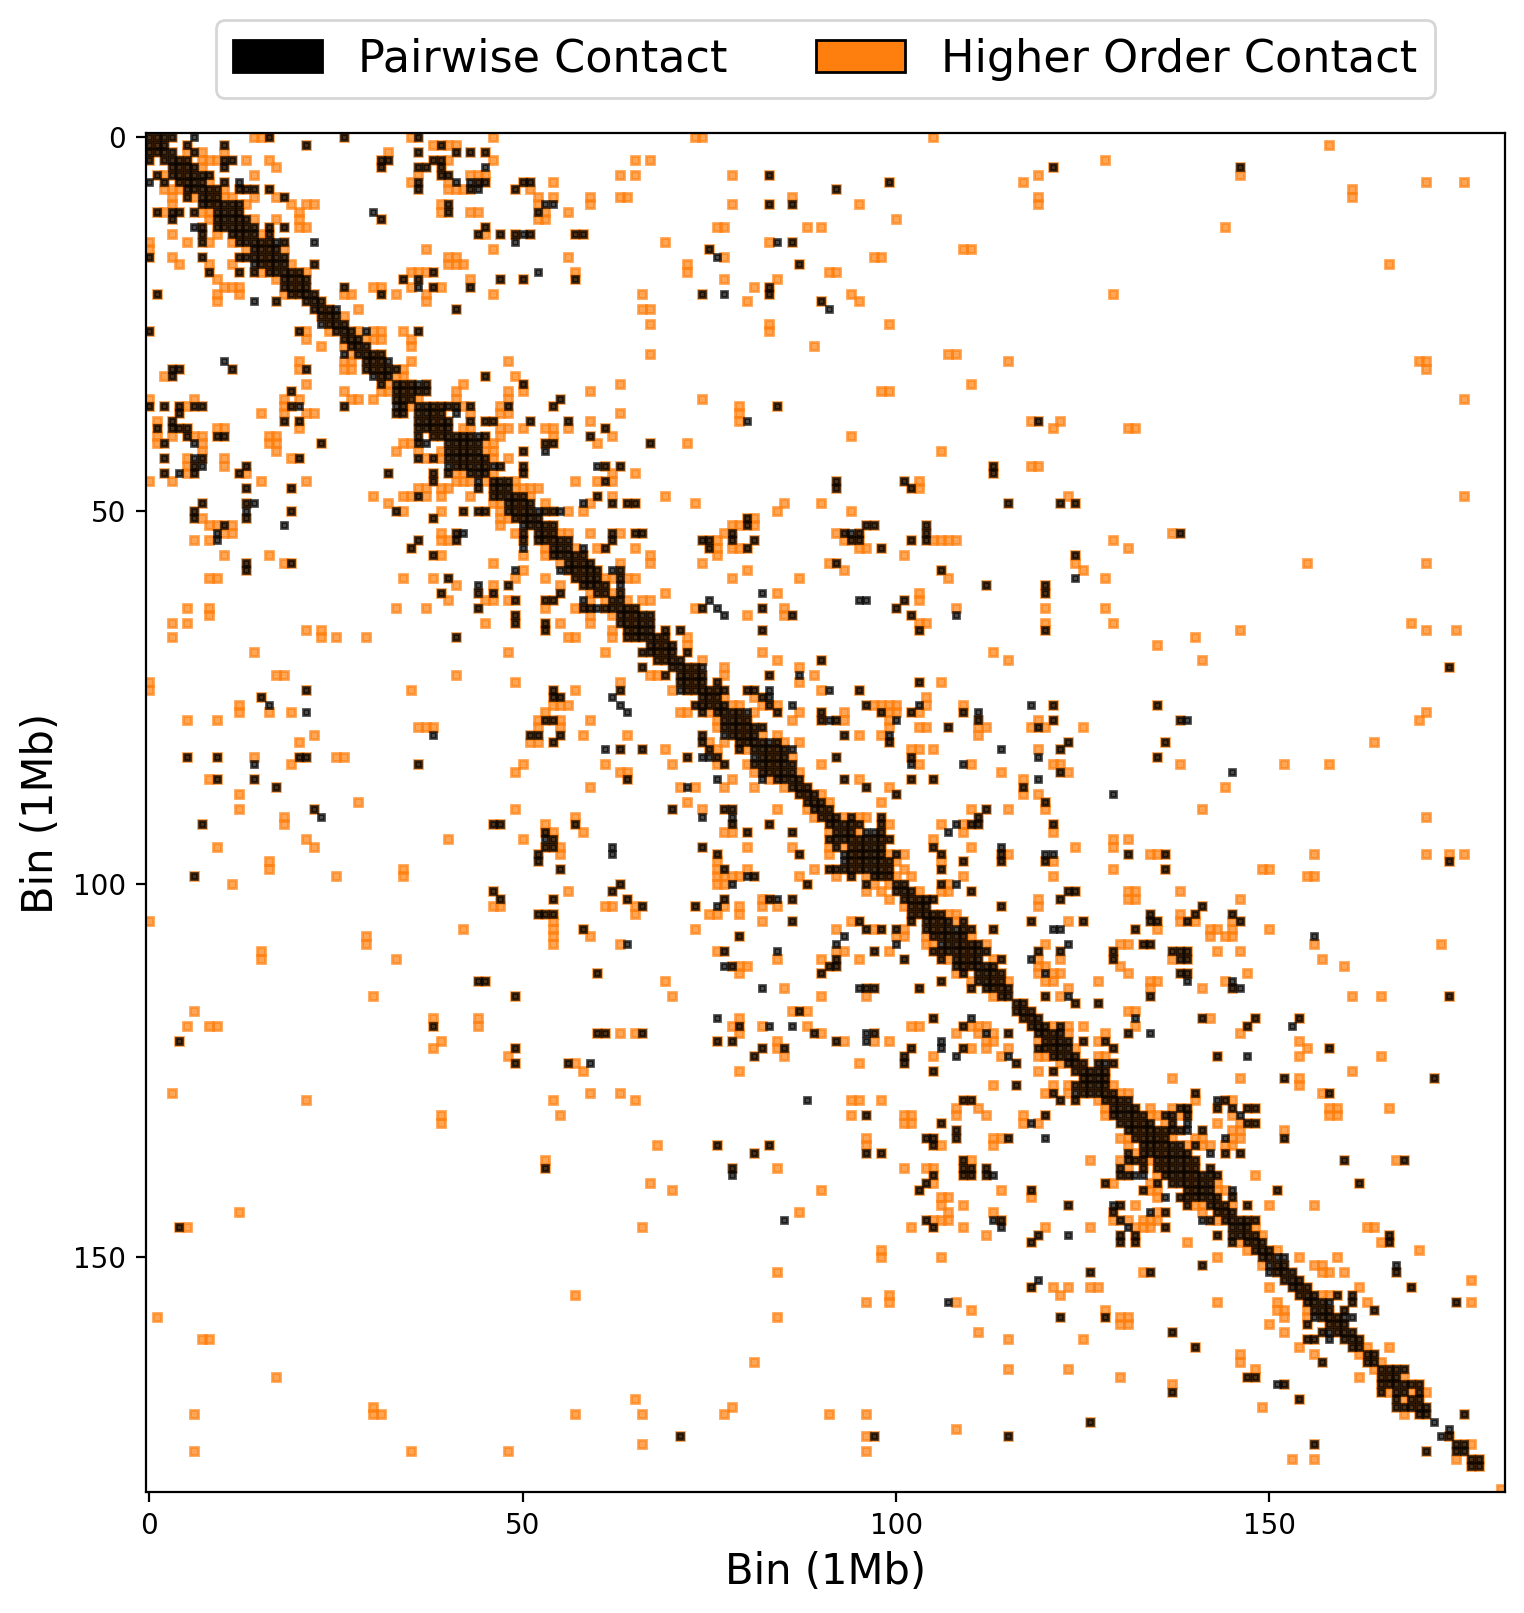

In [26]:
pairBulk = np.zeros((182, 182))
hoBulk = np.zeros((182, 182))

for runId, mats in chrom2Exp.items():
    
    pairBulk += mats['pairs']
    hoBulk += mats['higherOrder']
    
    
pairBulk = pcu.Abin(pairBulk)
hoBulk = pcu.Abin(hoBulk)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, 9
    
plt.spy(hoBulk, c='C1', alpha=0.7, marker='s', markersize=3)
plt.spy(pairBulk, c='k', alpha=0.7, marker='s', markersize=2)

plt.xlabel('Bin (1Mb)', fontsize=15)
plt.ylabel('Bin (1Mb)', fontsize=15)

ax = plt.gca()
ax.xaxis.tick_bottom()

# plt.xticks([], [])
# plt.yticks([], [])

ax.set_aspect('equal')

legend_elements = [Patch(facecolor='k', edgecolor='k', label='Pairwise Contact'),
                   Patch(facecolor='C1', edgecolor='k', label='Higher Order Contact')]

plt.legend(handles=legend_elements, loc='upper center',
           ncol=5, fontsize=16, bbox_to_anchor=(0.5, 1.1))

# Re-bin at multiple orders

In [19]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

ordMats = {}
ordDfs = {}
indShape = None

orders = [2, 3, 4, 5]

for order in orders:
    ordDf = exp[(exp['cell'] == cell) & (exp['order'] == order)].reset_index(drop=True)
    ordBinned = binning.wholeGenomeBinData(ordDf, bins, label1, label2)
    Aord = pcu.getHic(ordBinned, bins, label1, label2)

    print(f"{order=} {Aord.shape=}")
    indShape = Aord.shape[0]
    ordMats[order] =  Aord
    ordDfs[order] = ordDf
            
print('done.')

order=2 Aord.shape=(2724, 2724)
order=3 Aord.shape=(2724, 2724)
order=4 Aord.shape=(2724, 2724)
order=5 Aord.shape=(2724, 2724)
done.


In [20]:
chromosome = ['chr2']

chrom2 = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    return A
    

for runId in ordMats.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    Aord = processMat(ordMats[runId], ind)
    chrom2[runId] = Aord
    
    
print('done.')

done.


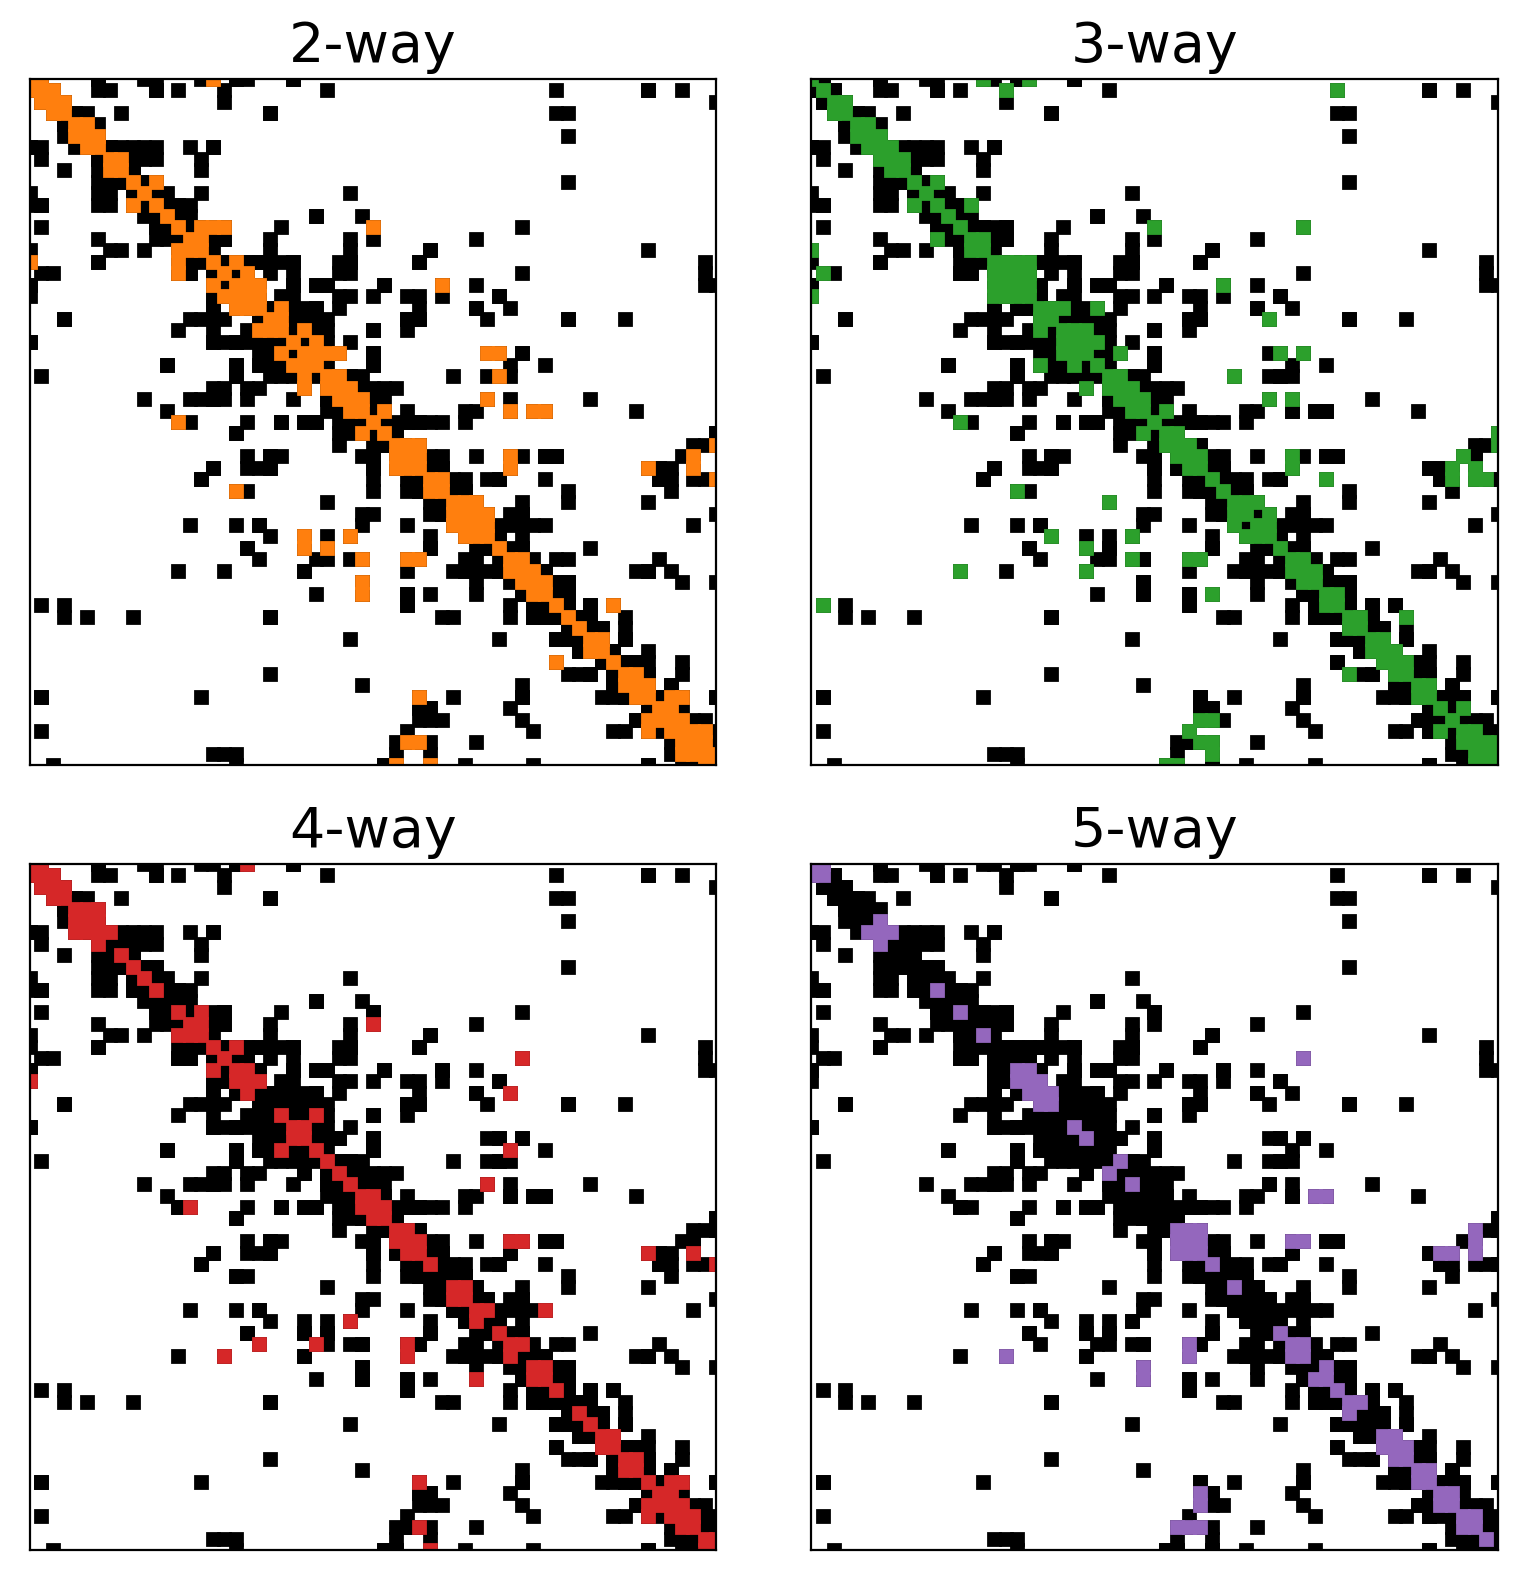

In [21]:
region = [20, 80]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 8

fig = plt.figure()

ens = np.zeros(Aord.shape)
colorNum = 0
figNum = 0
for order, A in chrom2.items():
    colorNum += 1
    figNum += 1
    
    ens += A
    
    fig.add_subplot(2, 2, figNum)
    
    plt.spy(A, c=f'C{colorNum}', marker='s', markersize=4, zorder=1)
    plt.spy(hoBulk, c='k', marker='s', markersize=4, zorder=0)
    plt.spy(pairBulk, c='k', marker='s', markersize=4, zorder=0)
    plt.xlim(region[0], region[1])
    plt.ylim(region[1], region[0])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{order}-way", fontsize=20)
    
    
plt.tight_layout()

([], [])

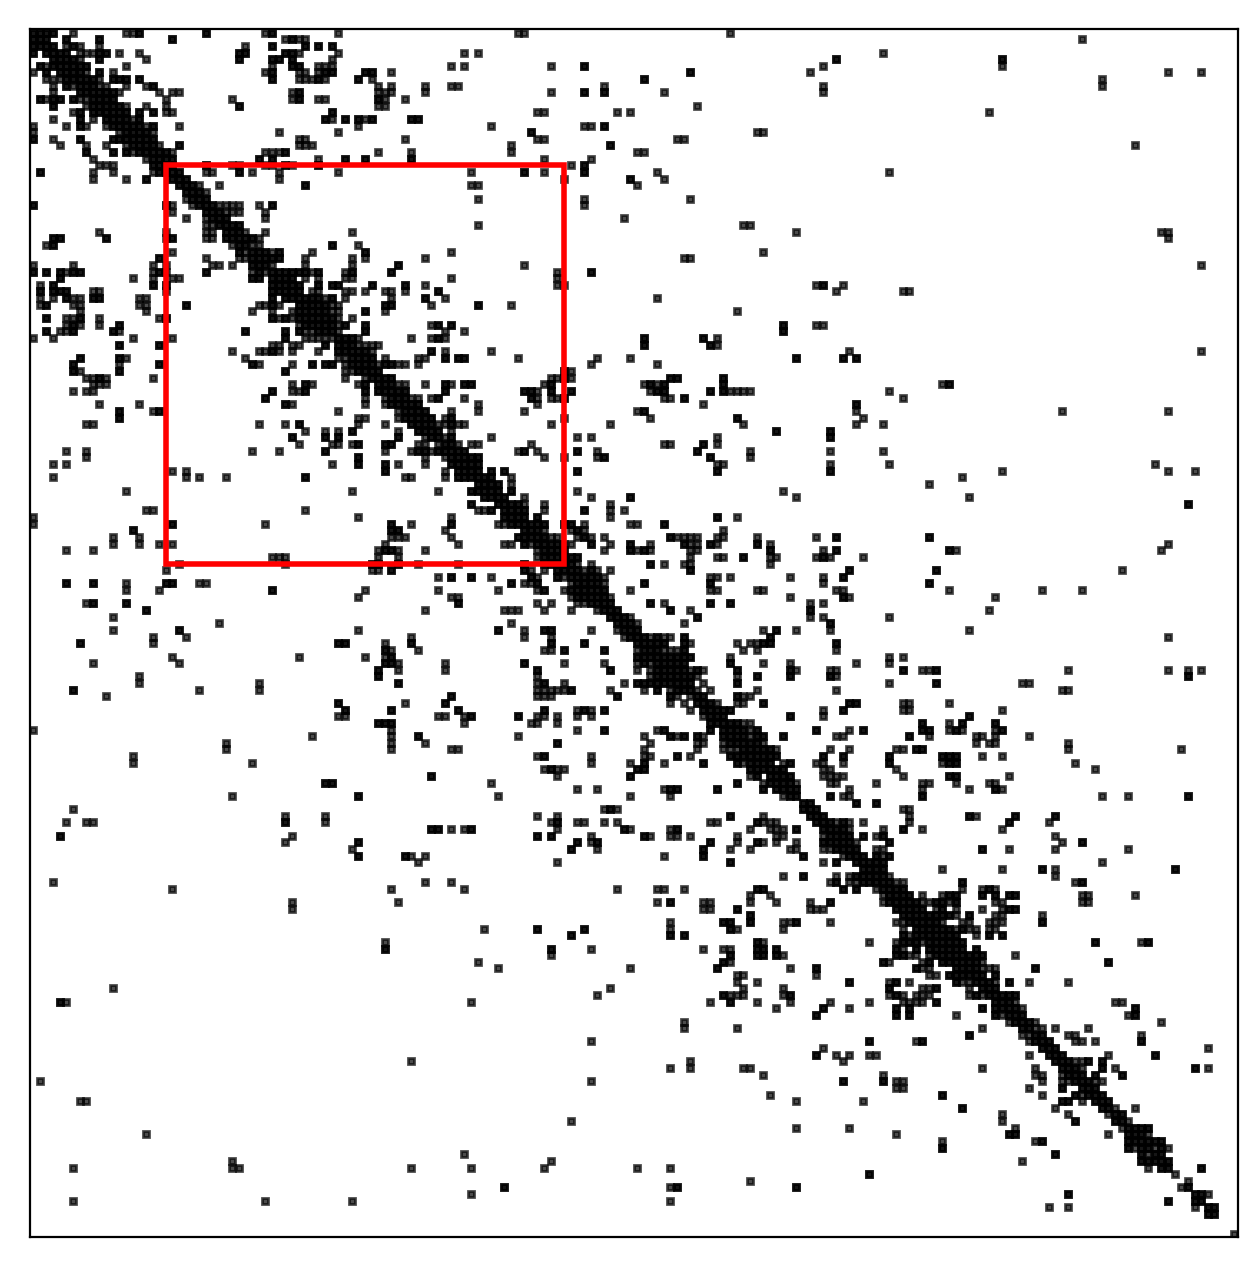

In [22]:
n = region[1] - region[0]

# plt.spy(ens)
plt.spy(hoBulk, c='k', alpha=0.7, marker='s', markersize=2, zorder=0)
plt.spy(pairBulk, c='k', alpha=0.7, marker='s', markersize=2, zorder=0)

ax = plt.gca()

rect = patches.Rectangle((region[0], region[0]), n, n, 
                         linewidth=2, 
                         edgecolor='r', 
                         facecolor='none',
                         zorder=1)
ax.add_patch(rect)

plt.xticks([], [])
plt.yticks([], [])


In [23]:
# chrom = '2'

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 8, 8

# for order, data in ordDfs.items():
    
#     dataChrm = data[(data['align1_chromosome_name'] == chrom) & (data['align2_chromosome_name'] == chrom)]
    
#     print(f"{data.shape=} {dataChrm.shape=}")
    
#     for readInd, read in enumerate(dataChrm['read_name'].unique()):
#         tmp = dataChrm[dataChrm['read_name'] == read]
        
#         readBins = tmp['bin1'].to_list() + tmp['bin2'].to_list()
#         readBins = list(set(readBins)) 
#         readBins = [i - 197 for i in readBins]
        
#         card = len(readBins)
        
#         if len(readBins) > 3:
#             print(read)
        
        
#         pltInd = [readInd+1] * card

#         plt.scatter(pltInd, 
#                     readBins,
#                     s=10, 
#                     alpha=0.8,
#                     facecolor=f"C{order-1}",
#                     edgecolor='None')

#         plt.plot(pltInd, 
#                  readBins,
#                  c = "k",
#                  alpha=0.5,
#                  lw=1)
            
        
#     plt.show()
        
